# Лабораторная работа №4

ФИО:  Власов Дмитрий Романович

Группа: БИВТ-20-3

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from IPython.display import display, HTML
from tqdm import tqdm
import time
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Загрузка данных

In [3]:
!pip install datasets  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.3 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset
dataset = load_dataset('keremberke/pokemon-classification', 'full')  # тут надо написать название вашего датасета

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset pokemon-classification downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___pokemon-classification/full/1.0.0/5193d0f863ed08164636296506df483caa6c9965bc05198ec2136417398e4b28. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#Описание датасета

Датасет состоит из картинок различных покемонов, которых предстоит классифицировать (отличить друг от друга).

Если обратить внимание на примеры картинок, то можно заметить, что данные уже в некоторой степени аугментированы (картинки одинакового размера 224x224, присутствуют одни и те же покемоны в нормальном и перевернутом вариантах, отраженные по горизонтали и тп)

Примеры картинок:

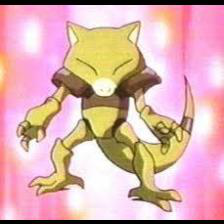

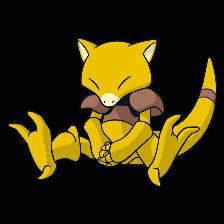

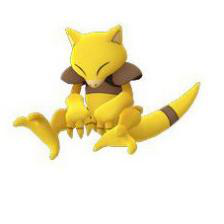

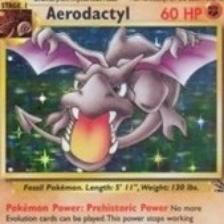

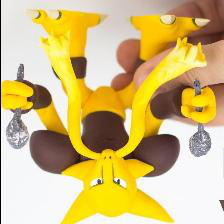

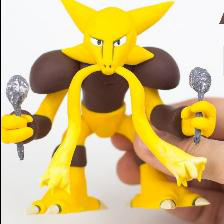

In [ ]:
sample_idx = [0, 22, 24, 60, 71, 72]
titles = ['Abra', 'Abra', 'Abra', 'Aerodactyl', 'Alakazam', 'Alakazam']
for i, idx in enumerate(sample_idx):
  title = title = f"<h2>{titles[i]}</h2>"
  display(HTML(title))
  display(dataset['train']['image'][idx])

# Оформление датасета

#### Оформление в виде объекта класса Dataset из PyTorch

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['labels']
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train, test = [CustomImageDataset(dataset[x], transform=data_transforms[x]) 
                  for x in ('train', 'validation')]


#### Оформление в Dataloader

In [7]:
dataloaders = {"train" : DataLoader(train, batch_size=4, shuffle=True),
               "test" : DataLoader(test, batch_size=4, shuffle=True)}
dataset_sizes = {"train" : len(train),
                 "test" : len(test)}
class_names = ['Porygon', 'Goldeen', 'Hitmonlee', 'Hitmonchan', 'Gloom', 'Aerodactyl', 'Mankey', 'Seadra', 'Gengar', 'Venonat', 'Articuno', 'Seaking', 'Dugtrio', 'Machop', 'Jynx', 'Oddish', 'Dodrio', 'Dragonair', 'Weedle', 'Golduck', 'Flareon', 'Krabby', 'Parasect', 'Ninetales', 'Nidoqueen', 'Kabutops', 'Drowzee', 'Caterpie', 'Jigglypuff', 'Machamp', 'Clefairy', 'Kangaskhan', 'Dragonite', 'Weepinbell', 'Fearow', 'Bellsprout', 'Grimer', 'Nidorina', 'Staryu', 'Horsea', 'Electabuzz', 'Dratini', 'Machoke', 'Magnemite', 'Squirtle', 'Gyarados', 'Pidgeot', 'Bulbasaur', 'Nidoking', 'Golem', 'Dewgong', 'Moltres', 'Zapdos', 'Poliwrath', 'Vulpix', 'Beedrill', 'Charmander', 'Abra', 'Zubat', 'Golbat', 'Wigglytuff', 'Charizard', 'Slowpoke', 'Poliwag', 'Tentacruel', 'Rhyhorn', 'Onix', 'Butterfree', 'Exeggcute', 'Sandslash', 'Pinsir', 'Rattata', 'Growlithe', 'Haunter', 'Pidgey', 'Ditto', 'Farfetchd', 'Pikachu', 'Raticate', 'Wartortle', 'Vaporeon', 'Cloyster', 'Hypno', 'Arbok', 'Metapod', 'Tangela', 'Kingler', 'Exeggutor', 'Kadabra', 'Seel', 'Voltorb', 'Chansey', 'Venomoth', 'Ponyta', 'Vileplume', 'Koffing', 'Blastoise', 'Tentacool', 'Lickitung', 'Paras', 'Clefable', 'Cubone', 'Marowak', 'Nidorino', 'Jolteon', 'Muk', 'Magikarp', 'Slowbro', 'Tauros', 'Kabuto', 'Spearow', 'Sandshrew', 'Eevee', 'Kakuna', 'Omastar', 'Ekans', 'Geodude', 'Magmar', 'Snorlax', 'Meowth', 'Pidgeotto', 'Venusaur', 'Persian', 'Rhydon', 'Starmie', 'Charmeleon', 'Lapras', 'Alakazam', 'Graveler', 'Psyduck', 'Rapidash', 'Doduo', 'Magneton', 'Arcanine', 'Electrode', 'Omanyte', 'Poliwhirl', 'Mew', 'Alolan Sandslash', 'Mewtwo', 'Weezing', 'Gastly', 'Victreebel', 'Ivysaur', 'MrMime', 'Shellder', 'Scyther', 'Diglett', 'Primeape', 'Raichu']

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

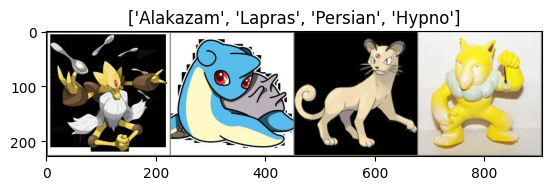

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Реализация архитектуры и тренировка нейросети

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):

    since = time.time()
  
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 53 * 53, 200)
        self.fc2 = nn.Linear(200, 150)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork()

In [22]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 44.96it/s]


train Loss: 4.1692 Acc: 0.0785


100%|██████████| 348/348 [00:05<00:00, 66.18it/s]


test Loss: 7.4499 Acc: 0.0014

Epoch 2/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 44.92it/s]


train Loss: 3.2146 Acc: 0.2150


100%|██████████| 348/348 [00:06<00:00, 58.00it/s]


test Loss: 11.1289 Acc: 0.0036

Epoch 3/10
--------------------


100%|██████████| 1218/1218 [00:28<00:00, 42.64it/s]


train Loss: 1.5797 Acc: 0.5820


100%|██████████| 348/348 [00:05<00:00, 67.09it/s]


test Loss: 16.2508 Acc: 0.0151

Epoch 4/10
--------------------


100%|██████████| 1218/1218 [00:26<00:00, 45.22it/s]


train Loss: 1.0581 Acc: 0.7186


100%|██████████| 348/348 [00:05<00:00, 58.14it/s]


test Loss: 17.5359 Acc: 0.0165

Epoch 5/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 45.09it/s]


train Loss: 0.6607 Acc: 0.8419


100%|██████████| 348/348 [00:05<00:00, 67.04it/s]


test Loss: 19.1722 Acc: 0.0173

Epoch 6/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 44.20it/s]


train Loss: 0.5979 Acc: 0.8556


100%|██████████| 348/348 [00:05<00:00, 62.24it/s]


test Loss: 20.3557 Acc: 0.0165

Epoch 7/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 44.06it/s]


train Loss: 0.5560 Acc: 0.8692


100%|██████████| 348/348 [00:06<00:00, 57.90it/s]


test Loss: 20.3912 Acc: 0.0165

Epoch 8/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 45.05it/s]


train Loss: 0.5515 Acc: 0.8712


100%|██████████| 348/348 [00:05<00:00, 67.03it/s]


test Loss: 20.4421 Acc: 0.0173

Epoch 9/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 45.08it/s]


train Loss: 0.5470 Acc: 0.8723


100%|██████████| 348/348 [00:05<00:00, 58.95it/s]


test Loss: 20.4502 Acc: 0.0173

Epoch 10/10
--------------------


100%|██████████| 1218/1218 [00:27<00:00, 44.97it/s]


train Loss: 0.5466 Acc: 0.8723


100%|██████████| 348/348 [00:05<00:00, 66.76it/s]

test Loss: 20.4582 Acc: 0.0173

Training complete in 5m 29s
Best test Acc: 0.017266


In [23]:
torch.save(model_ft.state_dict(), './net.pth')

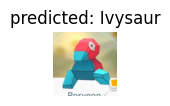

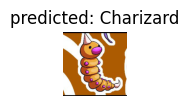

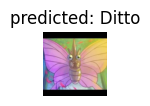

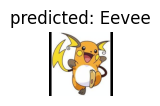

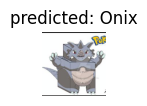

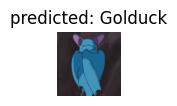

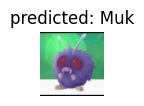

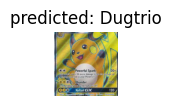

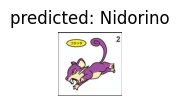

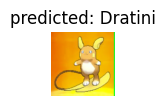

In [28]:
visualize_model(model_ft, 10)

# Дообучение с Transfer Learning

In [12]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 150)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 59.6MB/s]


In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
--------------------


100%|██████████| 1218/1218 [01:06<00:00, 18.33it/s]


train Loss: 3.8976 Acc: 0.1795


100%|██████████| 348/348 [00:15<00:00, 22.58it/s]


test Loss: 8.8447 Acc: 0.0072

Epoch 2/10
--------------------


100%|██████████| 1218/1218 [00:58<00:00, 20.93it/s]


train Loss: 2.2801 Acc: 0.5601


100%|██████████| 348/348 [00:15<00:00, 22.15it/s]


test Loss: 9.7901 Acc: 0.0151

Epoch 3/10
--------------------


100%|██████████| 1218/1218 [00:58<00:00, 20.64it/s]


train Loss: 1.5906 Acc: 0.7942


100%|██████████| 348/348 [00:15<00:00, 22.03it/s]


test Loss: 9.5468 Acc: 0.0151

Epoch 4/10
--------------------


100%|██████████| 1218/1218 [00:59<00:00, 20.51it/s]


train Loss: 1.5143 Acc: 0.8150


100%|██████████| 348/348 [00:15<00:00, 21.92it/s]


test Loss: 9.6692 Acc: 0.0129

Epoch 5/10
--------------------


100%|██████████| 1218/1218 [00:59<00:00, 20.41it/s]


train Loss: 1.4787 Acc: 0.8186


100%|██████████| 348/348 [00:15<00:00, 21.77it/s]


test Loss: 9.5403 Acc: 0.0122

Epoch 6/10
--------------------


100%|██████████| 1218/1218 [00:59<00:00, 20.33it/s]


train Loss: 1.4601 Acc: 0.8275


100%|██████████| 348/348 [00:15<00:00, 21.82it/s]


test Loss: 9.5396 Acc: 0.0122

Epoch 7/10
--------------------


100%|██████████| 1218/1218 [00:59<00:00, 20.41it/s]


train Loss: 1.4597 Acc: 0.8332


100%|██████████| 348/348 [00:15<00:00, 21.86it/s]


test Loss: 9.7193 Acc: 0.0144

Epoch 8/10
--------------------


100%|██████████| 1218/1218 [01:00<00:00, 20.24it/s]


train Loss: 1.4575 Acc: 0.8310


100%|██████████| 348/348 [00:16<00:00, 21.24it/s]


test Loss: 9.6712 Acc: 0.0122

Epoch 9/10
--------------------


100%|██████████| 1218/1218 [00:59<00:00, 20.42it/s]


train Loss: 1.4605 Acc: 0.8291


100%|██████████| 348/348 [00:15<00:00, 21.86it/s]


test Loss: 9.6417 Acc: 0.0129

Epoch 10/10
--------------------


100%|██████████| 1218/1218 [00:59<00:00, 20.35it/s]


train Loss: 1.4528 Acc: 0.8308


100%|██████████| 348/348 [00:15<00:00, 21.81it/s]

test Loss: 9.5906 Acc: 0.0122

Training complete in 12m 41s
Best test Acc: 0.015108


In [15]:
torch.save(model_conv.state_dict(), './net_tl.pth')

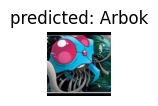

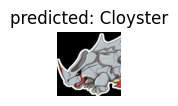

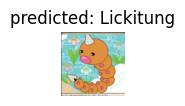

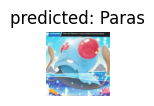

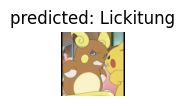

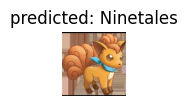

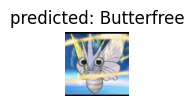

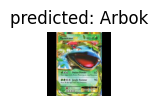

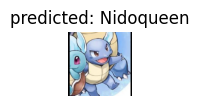

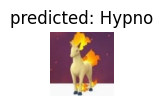

In [14]:
visualize_model(model_conv, 10)

# Посчитаем метрики качества наилучшей модели

In [40]:
def all_accuracy(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network: {100 * correct / total} %')

def class_accuracy(model, testloader):
    class_correct = list(0. for i in range(150))
    class_total = list(0. for i in range(150))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i, label in enumerate(labels):
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(150):
        if class_total[i] != 0:
            print(f'Accuracy of {class_names[i]} : {100 * class_correct[i] / class_total[i]} %')
        else:
            print(f"{class_names[i]} is not in test")

In [30]:
all_accuracy(model_ft, dataloaders['test'])

Accuracy of the network: 1.7266187050359711 %


In [41]:
class_accuracy(model_ft, dataloaders['test'])

Accuracy of Porygon : 0.0 %
Goldeen is not in test
Hitmonlee is not in test
Hitmonchan is not in test
Gloom is not in test
Aerodactyl is not in test
Mankey is not in test
Accuracy of Seadra : 0.0 %
Gengar is not in test
Accuracy of Venonat : 0.0 %
Articuno is not in test
Seaking is not in test
Dugtrio is not in test
Machop is not in test
Jynx is not in test
Oddish is not in test
Dodrio is not in test
Dragonair is not in test
Accuracy of Weedle : 0.0 %
Golduck is not in test
Flareon is not in test
Krabby is not in test
Parasect is not in test
Ninetales is not in test
Nidoqueen is not in test
Kabutops is not in test
Drowzee is not in test
Caterpie is not in test
Jigglypuff is not in test
Machamp is not in test
Clefairy is not in test
Kangaskhan is not in test
Dragonite is not in test
Accuracy of Weepinbell : 0.0 %
Fearow is not in test
Bellsprout is not in test
Grimer is not in test
Nidorina is not in test
Staryu is not in test
Horsea is not in test
Electabuzz is not in test
Dratini is n

Таким образом, в качестве вывода можно предположить, что в данном датасете имеется большое количество классов, на которые мы хотим производить классификацию изображений покемонов. И при большом количестве классов не хватает данных для обучения и валидации, следствием чего являются низкиме метрики